Filenames that will be included in this heatmap: 

control1_rr182_exp3_bc8_610537_taxon_report.csv
sample2_rr182_exp3_bc6_610540_taxon_report.csv
sample1_rr182_exp3_bc5_610539_taxon_report.csv
control2_rr182_exp3_bc10_610538_taxon_report.csv
sample6_rr182_exp3_bc12_610544_taxon_report.csv
sample4_rr182_exp3_bc9_610542_taxon_report.csv
sample5_rr182_exp3_bc11_610543_taxon_report.csv
sample3_rr182_exp3_bc7_610541_taxon_report.csv





Enter the numbers of the control samples separated by commas:  1,4


,control1_rr182_exp3_bc8,control2_rr182_exp3_bc10,sample1_rr182_exp3_bc5,sample2_rr182_exp3_bc6,sample3_rr182_exp3_bc7,sample4_rr182_exp3_bc9,sample5_rr182_exp3_bc11,sample6_rr182_exp3_bc12
name,,,,,,,,
Moraxella catarrhalis,NaN,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
Lawsonella clevelandensis,NaN,NaN,100.000000,100.000000,NaN,100.000000,100.000000,NaN
Corynebacterium kroppenstedtii,NaN,NaN,NaN,100.000000,NaN,100.000000,100.000000,NaN
Klebsiella aerogenes,NaN,NaN,100.000000,100.000000,NaN,NaN,100.000000,NaN
Klebsiella pneumoniae,NaN,NaN,NaN,100.000000,NaN,NaN,100.000000,NaN
...,...,...,...,...,...,...,...,...
Delftia tsuruhatensis,0.707107,-0.707107,NaN,NaN,NaN,-0.704903,NaN,-0.707502
Delftia acidovorans,0.707107,-0.707107,NaN,NaN,-0.710021,-0.709428,-0.707972,NaN
Corynebacterium propinquum,-0.707107,0.707107,-1.038282,-1.040259,-1.040927,-1.037811,-1.001222,2.187155


Enter the z-score threshold:  10


/tmp/ipykernel_969158/134746770.py:114: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  original_plot_df = original_plot_df.loc[all_top_n_taxa]
/tmp/ipykernel_969158/134746770.py:115: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  new_plot_df = new_plot_df.loc[all_top_n_taxa]


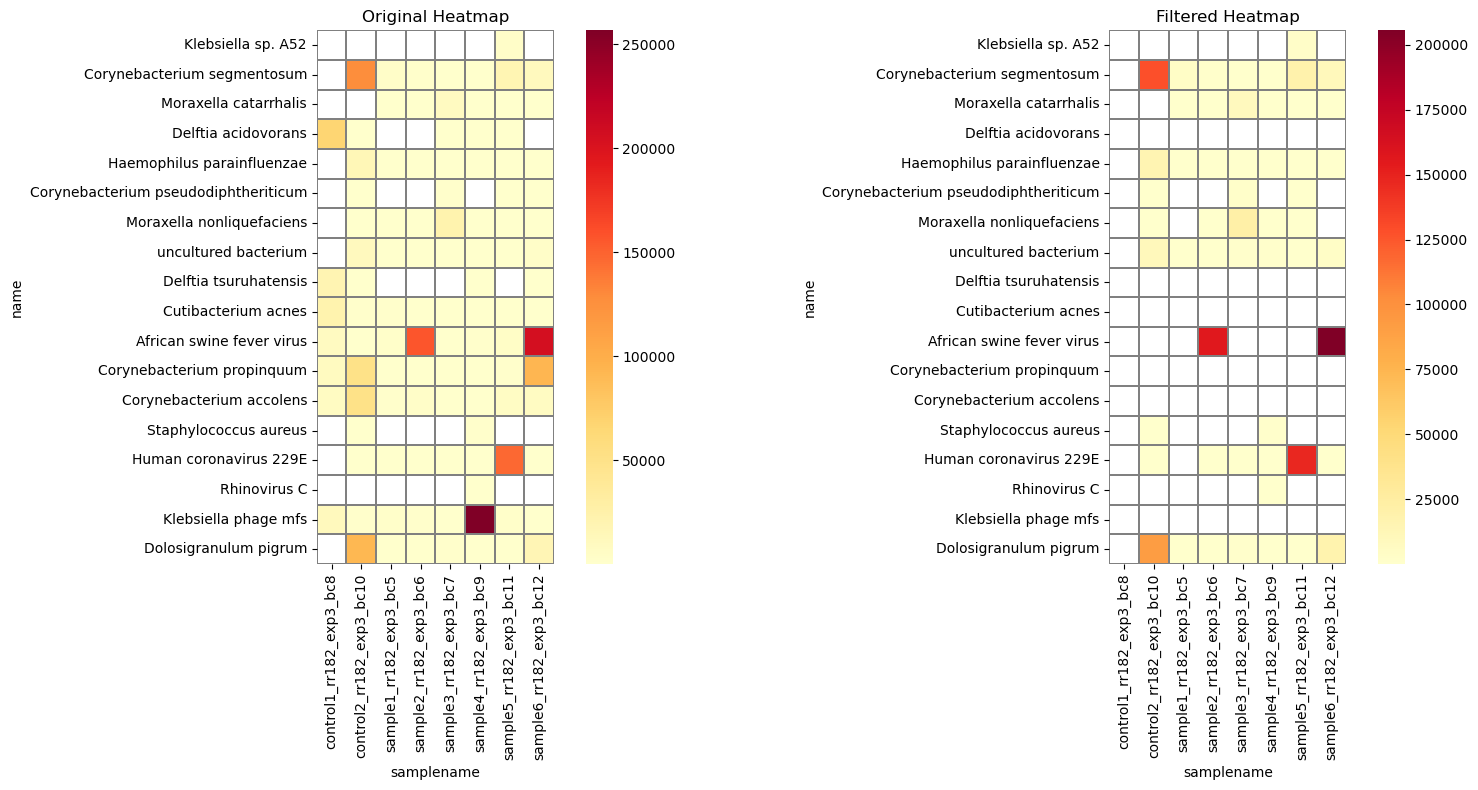

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuration
data_directory = 'RR_182'
METRIC = 'nt_bpm'
TAX_LEVEL = [1]
CATEGORY_LIST = ['viruses', 'bacteria']
MIN_NT_BPM = 10
MIN_NR_BPM = 0
MIN_NT_CONTIGS = 0 
MIN_NR_CONTIGS = 0
TOP_N = 5
LOG_TRANSFORM = False
FIGURE_SIZE = (8, 8)

def read_czid_report(filename, metric='nt_bpm', tax_level=[], category_list=[], min_nt_bpm=1, min_nr_bpm=1, min_nt_contigs=0, min_nr_contigs=0):
    df = pd.read_csv(filename)
    df.fillna(0, inplace=True)
    
    # filter on tax_level
    if len(tax_level) > 0:
        df = df.loc[df['tax_level'].isin(tax_level)]
        
    # select only categories of interest
    if len(category_list) > 0:
        df = df.loc[df['category'].isin(category_list)]
    
    # apply filters on specific data columns
    df = df[df['nt_bpm'] >= min_nt_bpm]
    df = df[df['nr_bpm'] >= min_nr_bpm]
    df = df[df['nt_contig_b'] >= min_nt_contigs]
    df = df[df['nr_contig_b'] >= min_nr_contigs]

    df['samplename'] = ['_'.join(filename.split('/')[-1].split('_')[0:-3]) for i in range(len(df.index))]
    
    return df

def calculate_stats(df):
    mean = df.mean(axis=1)
    std_dev = df.std(axis=1, ddof=1)
    return mean, std_dev

def calculate_z_scores(big_df, controls_df, samples_df, control_mean, control_std_dev):
    all_samples = big_df.pivot(index='name', columns='samplename', values='nt_bpm')
    
    z_scores_df = pd.DataFrame(index=all_samples.index)

    for sample in all_samples.columns:
        z_scores = []
        for microbe in all_samples.index:
            value = all_samples.loc[microbe, sample]
            if pd.isna(value):
                z_scores.append(np.nan)
            elif value > 0 and (microbe not in controls_df.index or controls_df.loc[microbe].fillna(0).eq(0).all()):
                z_scores.append(100)
            elif value == 0 and (microbe in controls_df.index and controls_df.loc[microbe].fillna(0).gt(0).any()):
                z_scores.append(-100)
            else:
                if microbe in control_mean.index and control_std_dev[microbe] == 0:
                    z_score = 0 if value == control_mean[microbe] else (100 if value > control_mean[microbe] else -100)
                elif microbe in control_mean.index:
                    z_score = (value - control_mean[microbe]) / control_std_dev[microbe]
                else:
                    z_score = np.nan
                z_scores.append(max(min(z_score, 100), -100))
        z_scores_df[sample] = z_scores
    
    z_scores_df.replace("NaN", "not in sample", inplace=True)
    
    # Add a column to count the number of 'not in sample' for each microbe
    z_scores_df['not_in_sample_count'] = (z_scores_df == 'not in sample').sum(axis=1)
    
    # Sort the dataframe by the number of 'not in sample', with the most at the bottom
    z_scores_df.sort_values(by='not_in_sample_count', ascending=True, inplace=True)
    
    # Drop the helper column
    z_scores_df.drop(columns=['not_in_sample_count'], inplace=True)
    
    return z_scores_df

def plot_czid_heatmap(df, plot_value='nt_bpm', top_n=10, figure_size=(8, 8), log=False, sort_values=True, output_filename='output.pdf'):
    plot_df = df.pivot(index='name', columns='samplename', values=plot_value)
    
    x = plot_df.unstack().groupby(level=0, group_keys=False).nlargest(top_n).to_frame()
    all_top_n_taxa = set([i[1] for i in x.index])
    plot_df = plot_df.loc[all_top_n_taxa]  
    
    if sort_values:
        plot_df.sort_index(inplace=True)
    
    if log:
        plot_df = np.log(plot_df + 1)
        
    czid_colors = sns.color_palette("YlOrRd", as_cmap=True)  
    
    plt.figure(figsize=figure_size)
    sns.heatmap(plot_df, cmap=czid_colors, linewidths=.1, linecolor='grey', 
                square=True, xticklabels=True, yticklabels=True) 
    plt.tight_layout()
    plt.savefig(output_filename)
    plt.show()

def plot_side_by_side(original_df, new_df, metric='nt_bpm', top_n=10, figure_size=(16, 8), log=False, output_filename='side_by_side.pdf'):
    original_plot_df = original_df.pivot(index='name', columns='samplename', values=metric)
    new_plot_df = new_df.pivot(index='name', columns='samplename', values=metric)

    x = original_plot_df.unstack().groupby(level=0, group_keys=False).nlargest(top_n).to_frame()
    all_top_n_taxa = set([i[1] for i in x.index])
    
    original_plot_df = original_plot_df.loc[all_top_n_taxa]
    new_plot_df = new_plot_df.loc[all_top_n_taxa]

    if log:
        original_plot_df = np.log(original_plot_df + 1)
        new_plot_df = np.log(new_plot_df + 1)
        
    czid_colors = sns.color_palette("YlOrRd", as_cmap=True)

    fig, axes = plt.subplots(ncols=2, figsize=figure_size)
    sns.heatmap(original_plot_df, cmap=czid_colors, linewidths=.1, linecolor='grey', 
                square=True, xticklabels=True, yticklabels=True, ax=axes[0])
    sns.heatmap(new_plot_df, cmap=czid_colors, linewidths=.1, linecolor='grey', 
                square=True, xticklabels=True, yticklabels=True, ax=axes[1])

    axes[0].set_title('Original Heatmap')
    axes[1].set_title('Filtered Heatmap')

    plt.tight_layout()
    plt.savefig(output_filename)
    plt.show()

def main():
    files = [file for file in os.listdir(data_directory) if file.endswith('.csv')]
    print("Filenames that will be included in this heatmap: \n")
    for file in os.listdir(data_directory):
        if file.endswith(".csv"):
            print(file)

    print("\n\n")

    results_matrix_list = []
    for file in os.listdir(data_directory):
        if file.endswith('.csv'):
            try:
                df = pd.read_csv(os.path.join(data_directory, file))
                if df.empty:
                    continue
            except pd.errors.EmptyDataError:
                continue

            big_df = read_czid_report(os.path.join(data_directory, file), 
                                  metric=METRIC,
                                  tax_level=TAX_LEVEL, 
                                  category_list=CATEGORY_LIST,
                                  min_nt_bpm=MIN_NT_BPM,
                                  min_nr_bpm=MIN_NR_BPM,
                                  min_nt_contigs=MIN_NT_CONTIGS, 
                                  min_nr_contigs=MIN_NR_CONTIGS)

            results_matrix_list.append(big_df)

    big_df = pd.concat(results_matrix_list, axis=0)
    
    control_indices = input("Enter the numbers of the control samples separated by commas: ")
    control_indices = [int(index.strip()) - 1 for index in control_indices.split(',')]

    control_sample_names = [results_matrix_list[i]['samplename'].unique()[0] for i in control_indices]
    sample_sample_names = [results_matrix_list[i]['samplename'].unique()[0] for i in range(len(results_matrix_list)) if i not in control_indices]
    
    controls_df = pd.concat([results_matrix_list[i] for i in control_indices], ignore_index=True)
    samples_df = pd.concat([results_matrix_list[i] for i in range(len(results_matrix_list)) if i not in control_indices], ignore_index=True)
    
    controls_df = controls_df.pivot(index='name', columns='samplename', values='nt_bpm')
    samples_df = samples_df.pivot(index='name', columns='samplename', values='nt_bpm')

    control_mean, control_std_dev = calculate_stats(controls_df)
    z_scores_df = calculate_z_scores(big_df, controls_df, samples_df, control_mean, control_std_dev)
    
    row_sums = z_scores_df.sum(axis=1)
    sorted_z_scores_df = z_scores_df.loc[row_sums.sort_values(ascending=False).index]

    display(sorted_z_scores_df)

    z_score_threshold = float(input("Enter the z-score threshold: "))

    filtered_big_df = big_df.copy()
    for index, row in filtered_big_df.iterrows():
        name = row['name']
        samplename = row['samplename']
        if name in z_scores_df.index and z_scores_df.at[name, samplename] < z_score_threshold:
            filtered_big_df.at[index, METRIC] = np.nan

    plot_side_by_side(big_df, filtered_big_df, metric=METRIC, top_n=TOP_N, figure_size=(16, 8), log=LOG_TRANSFORM, output_filename='side_by_side.pdf')

if __name__ == "__main__":
    main()
